In [15]:
!pip3 install plotly

In [27]:
!pip3 install -U kaleido

Requirement already up-to-date: kaleido in c:\users\shaha\anaconda3\lib\site-packages (0.2.1)


In [225]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import plotly.express as px

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 1 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,request.Attack_Tag,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,Directory Traversal,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,NaN,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,Cookie Injection,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,NaN,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,LOG4J,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [226]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",NaN,NaN,NaN,NaN,Directory Traversal,Malware
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,NaN,NaN,NaN,Cookie Injection,Malware
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",NaN,NaN,NaN,NaN,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN,LOG4J,Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=wKm-iDQeCXGjwXGrGJvfzWzs5VYbnWSP75B6BjFz1...,"Mon, 21 Nov 2022 18:39:51 GMT",POST,http://127.0.0.1:5000/cookielogin,,302 FOUND,text/html; charset=utf-8,211,302,<!doctype html>\n<html lang=en>\n<title>Redire...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,/cookielogin,0,username=gASVKgAAAAAAAACMCF9fbWFpbl9flIwGUGVyc...,Cookie Injection,Malware
4278,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=oyXTP1KfNdMwWb_jIYEQYKzE9RZALsuCGCtJtUlju...,"Mon, 21 Nov 2022 18:39:51 GMT",GET,http://127.0.0.1:5000/orders/get/id/7668,,404 NOT FOUND,application/json,36,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign
4279,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=bfYOeMnpxlFA9F7ObPemhCXYmeYNbBteewfAWbnfy...,"Mon, 21 Nov 2022 18:39:52 GMT",POST,http://127.0.0.1:5000/cookielogin,,302 FOUND,text/html; charset=utf-8,211,302,<!doctype html>\n<html lang=en>\n<title>Redire...,username=gASVyAAAAAAAAACMCGJ1aWx0aW5zlIw

In [227]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",None,None,None,None,Directory Traversal,Malware
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,None,None,None,Cookie Injection,Malware
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,LOG4J,Malware


In [228]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                'request.headers.Connection',
                'request.headers.Host',
                'request.headers.Accept',
                'request.method',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Site',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.Sec-Fetch-Dest',
                'request.headers.Sec-Fetch-User',
                'response.status',
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                    'request.headers.Set-Cookie',
                    'request.headers.Date',
                    'request.url',
                    'response.headers.Content-Type',
                    'response.body',
                    'response.headers.Location',
                    'request.headers.Content-Length',
                    'request.headers.Cookie',
                    'response.headers.Set-Cookie'
                    ]

COLUMNS_TO_REMOVE = ['request.body',
                    'response.headers.Content-Length',
                    'request.headers.Date']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=3)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()
    
    

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,0,-0.235702,0,0,0,1,0,0,0,0,0.192450,0,0.000000,0,0.000000,200,0.301511,0.000000,0.0,0.0,0.0,Directory Traversal,Malware
1,0,0.000000,0,0,0,0,0,0,0,0,0.259828,0,-0.894427,4,0.000000,404,0.666667,0.000000,0.0,0.0,0.0,Benign,Benign
2,0,0.577350,0,0,0,0,0,0,0,0,-0.176090,0,0.707107,0,-0.408248,200,-1.000000,-0.316228,0.0,0.0,0.0,Cookie Injection,Malware
3,0,-0.666667,0,0,0,1,0,0,0,0,0.215387,0,0.000000,4,0.000000,404,0.894427,0.000000,0.0,0.0,0.0,Benign,Benign
4,0,0.577350,0,0,0,0,0,0,0,29,0.274721,0,-0.577350,4,0.000000,404,0.666667,0.000000,0.0,0.0,0.0,LOG4J,Malware


In [229]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   request.headers.Host             4282 non-null   int32  
 1   request.headers.User-Agent       4282 non-null   float64
 2   request.headers.Accept-Encoding  4282 non-null   int32  
 3   request.headers.Accept           4282 non-null   int32  
 4   request.headers.Connection       4282 non-null   int32  
 5   request.headers.Accept-Language  4282 non-null   int32  
 6   request.headers.Sec-Fetch-Site   4282 non-null   int32  
 7   request.headers.Sec-Fetch-Mode   4282 non-null   int32  
 8   request.headers.Sec-Fetch-User   4282 non-null   int32  
 9   request.headers.Sec-Fetch-Dest   4282 non-null   int32  
 10  request.headers.Set-Cookie       4282 non-null   float64
 11  request.method                   4282 non-null   int32  
 12  request.url         

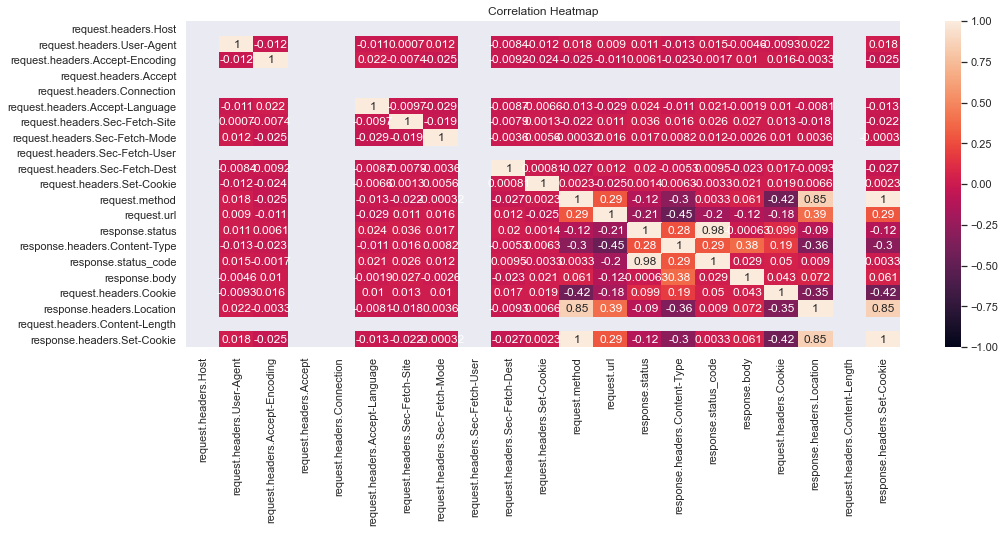

In [230]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

# #remove columns that are with 1 correlation

In [231]:
df.drop('response.headers.Set-Cookie', axis=1, inplace=True)
# df.drop('request.method', axis=1, inplace=True)
df.drop('response.status_code', axis=1, inplace=True)
# df.drop('response.headers.Location', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,attack_type,label
0,0,-0.235702,0,0,0,1,0,0,0,0,0.192450,0,0.000000,0,0.000000,0.301511,0.000000,0.0,0.0,Directory Traversal,Malware
1,0,0.000000,0,0,0,0,0,0,0,0,0.259828,0,-0.894427,4,0.000000,0.666667,0.000000,0.0,0.0,Benign,Benign
2,0,0.577350,0,0,0,0,0,0,0,0,-0.176090,0,0.707107,0,-0.408248,-1.000000,-0.316228,0.0,0.0,Cookie Injection,Malware
3,0,-0.666667,0,0,0,1,0,0,0,0,0.215387,0,0.000000,4,0.000000,0.894427,0.000000,0.0,0.0,Benign,Benign
4,0,0.577350,0,0,0,0,0,0,0,29,0.274721,0,-0.577350,4,0.000000,0.666667,0.000000,0.0,0.0,LOG4J,Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,0,0.000000,0,0,0,2,0,1,0,0,0.000000,1,0.707107,1,-0.408248,0.154303,0.000000,1.0,0.0,Cookie Injection,Malware
4278,0,0.000000,0,0,0,0,0,0,0,0,0.381000,0,0.000000,4,0.000000,-0.447214,0.000000,0.0,0.0,Benign,Benign
4279,0,0.000000,0,0,0,1,0,0,0,0,-0.371391,1,0.707107,1,-0.408248,0.154303,0.000000,1.0,0.0,Cookie Injection,Malware
4280,0,0.000000,0,0,0,1,0,0,0,0,-0.588348,0,-0.447214,4,0.000000,0.666667,0.000000,0.0,0.0,Benign,Benign


## check which fields always have the same value (they have no impact)

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


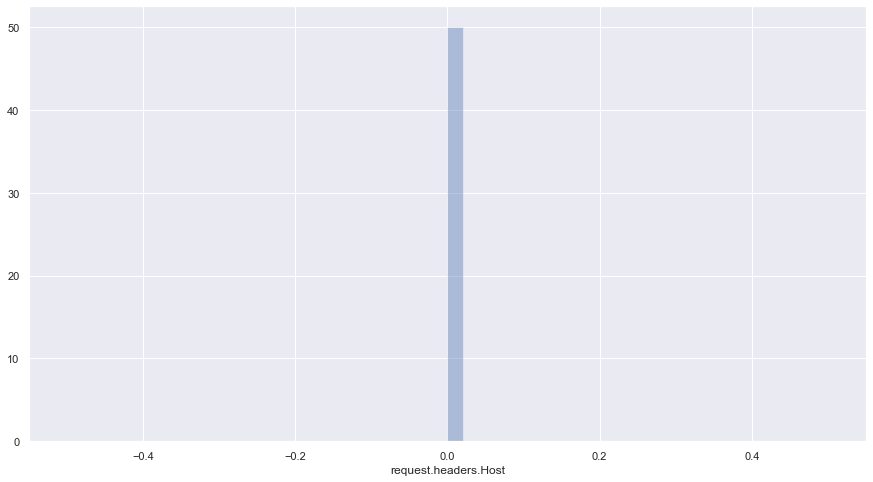

In [232]:
sns.distplot(df['request.headers.Host'])

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


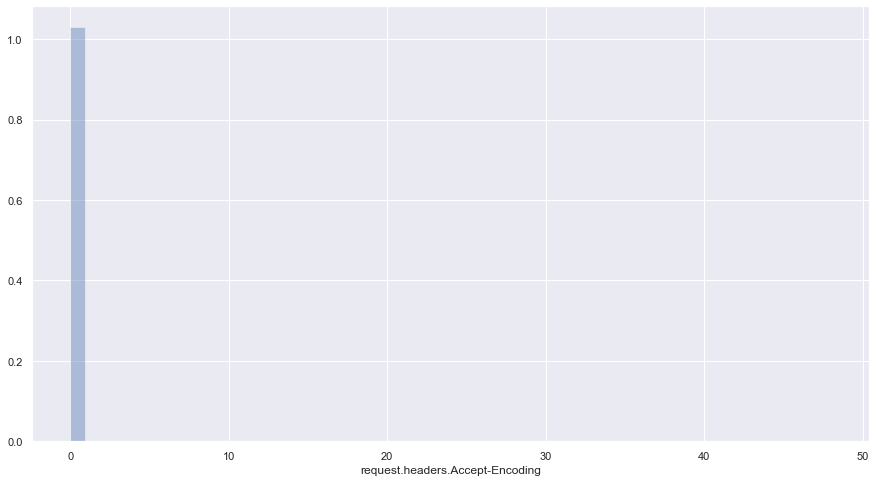

In [233]:
sns.distplot(df['request.headers.Accept-Encoding'])

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


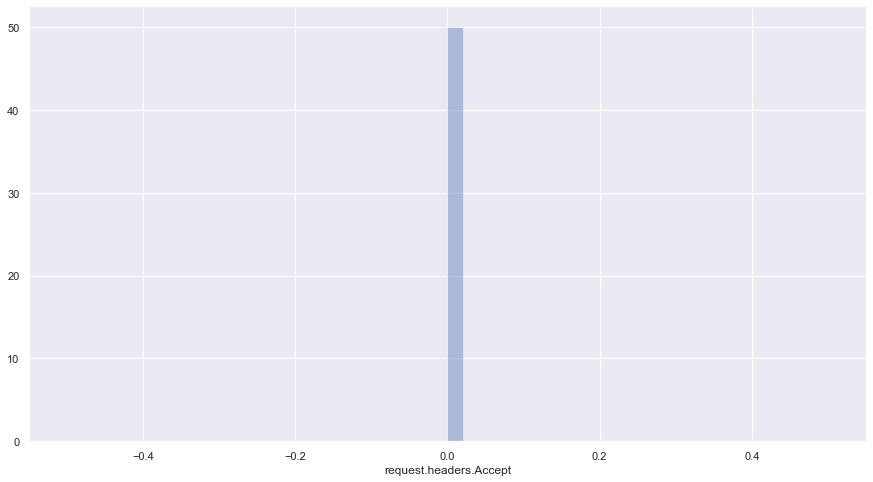

In [234]:
sns.distplot(df['request.headers.Accept'])

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


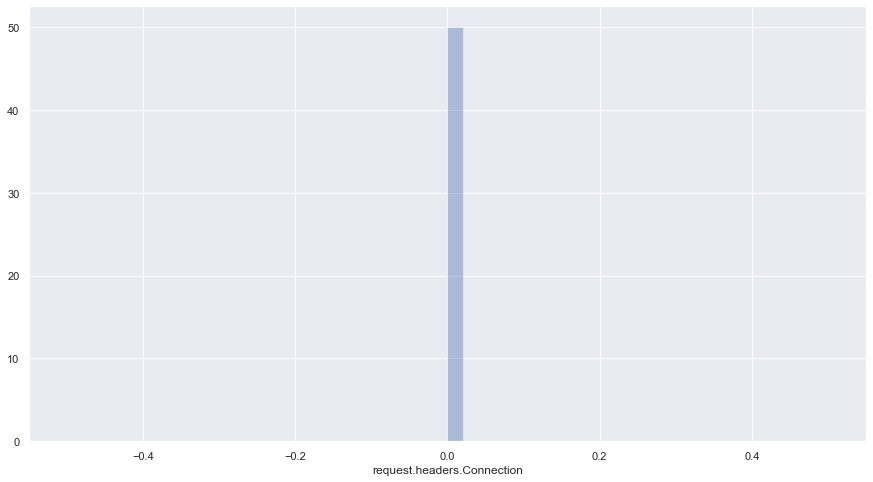

In [235]:
sns.distplot(df['request.headers.Connection'])

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


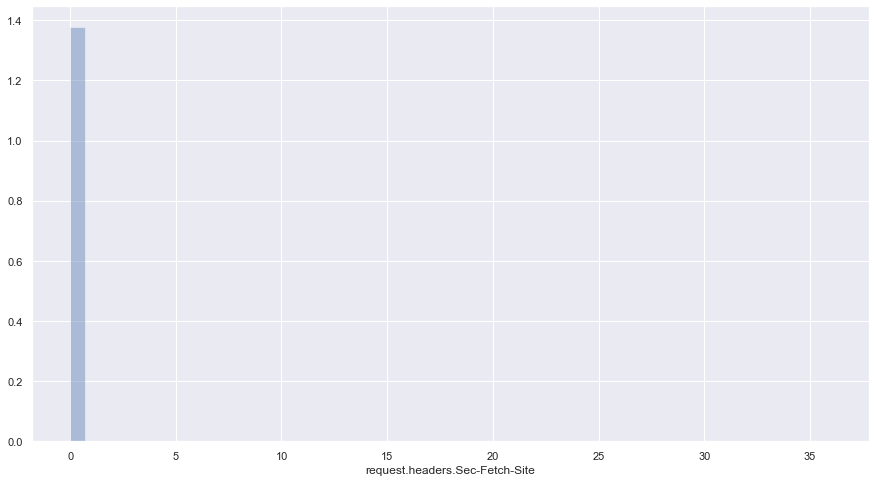

In [236]:
sns.distplot(df['request.headers.Sec-Fetch-Site'])

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


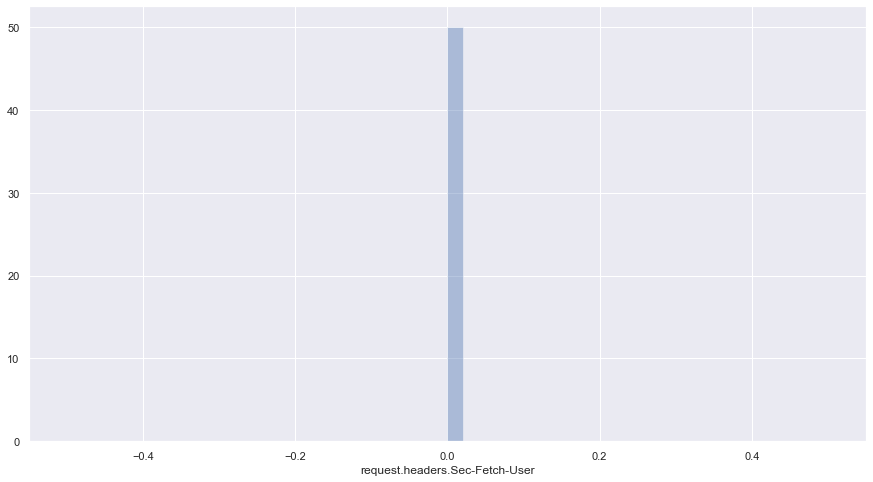

In [237]:
sns.distplot(df['request.headers.Sec-Fetch-User'])

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


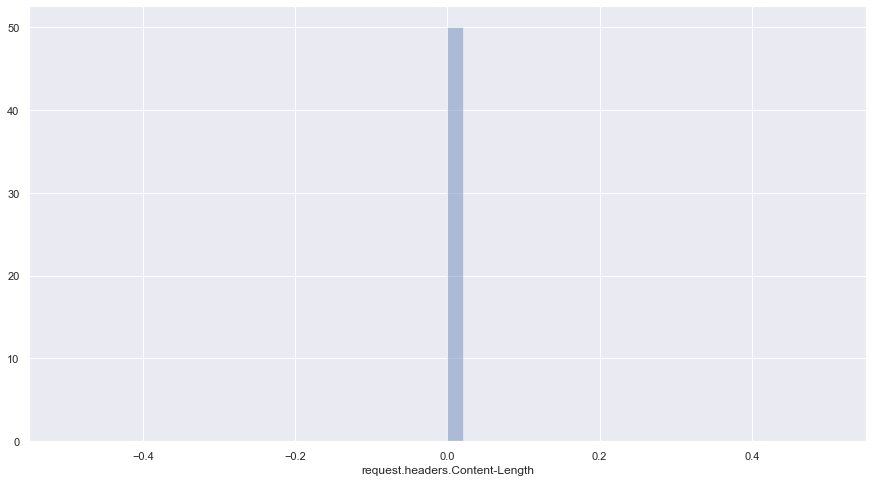

In [238]:
sns.distplot(df['request.headers.Content-Length'])

## drop fields that have no impact

In [239]:
df.drop('request.headers.Host', axis=1, inplace=True)
# df.drop('request.headers.Accept-Encoding', axis=1, inplace=True)
# df.drop('request.headers.Accept', axis=1, inplace=True)
# df.drop('request.headers.Connection', axis=1, inplace=True)
# df.drop('request.headers.Sec-Fetch-Site', axis=1, inplace=True)
df.drop('request.headers.Content-Length', axis=1, inplace=True)
# df.drop('request.headers.Sec-Fetch-User', axis=1, inplace=True)

df

,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.body,request.headers.Cookie,response.headers.Location,attack_type,label
0,-0.235702,0,0,0,1,0,0,0,0,0.192450,0,0.000000,0,0.000000,0.301511,0.000000,0.0,Directory Traversal,Malware
1,0.000000,0,0,0,0,0,0,0,0,0.259828,0,-0.894427,4,0.000000,0.666667,0.000000,0.0,Benign,Benign
2,0.577350,0,0,0,0,0,0,0,0,-0.176090,0,0.707107,0,-0.408248,-1.000000,-0.316228,0.0,Cookie Injection,Malware
3,-0.666667,0,0,0,1,0,0,0,0,0.215387,0,0.000000,4,0.000000,0.894427,0.000000,0.0,Benign,Benign
4,0.577350,0,0,0,0,0,0,0,29,0.274721,0,-0.577350,4,0.000000,0.666667,0.000000,0.0,LOG4J,Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,0.000000,0,0,0,2,0,1,0,0,0.000000,1,0.707107,1,-0.408248,0.154303,0.000000,1.0,Cookie Injection,Malware
4278,0.000000,0,0,0,0,0,0,0,0,0.381000,0,0.000000,4,0.000000,-0.447214,0.000000,0.0,Benign,Benign
4279,0.000000,0,0,0,1,0,0,0,0,-0.371391,1,0.707107,1,-0.408248,0.154303,0.000000,1.0,Cookie Injection,Malware
4280,0.000000,0,0,0,1,0,0,0,0,-0.588348,0,-0.447214,4,0.000000,0.666667,0.000000,0.0,Benign,Benign


In [240]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept', 'request.headers.Connection', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-User', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Type', 'response.body', 'request.headers.Cookie', 'response.headers.Location']


request.headers.User-Agent         float64
request.headers.Accept-Encoding      int32
request.headers.Accept               int32
request.headers.Connection           int32
request.headers.Accept-Language      int32
request.headers.Sec-Fetch-Site       int32
request.headers.Sec-Fetch-Mode       int32
request.headers.Sec-Fetch-User       int32
request.headers.Sec-Fetch-Dest       int32
request.headers.Set-Cookie         float64
request.method                       int32
request.url                        float64
response.status                      int32
response.headers.Content-Type      float64
response.body                      float64
request.headers.Cookie             float64
response.headers.Location          float64
attack_type                         object
label                               object
dtype: object

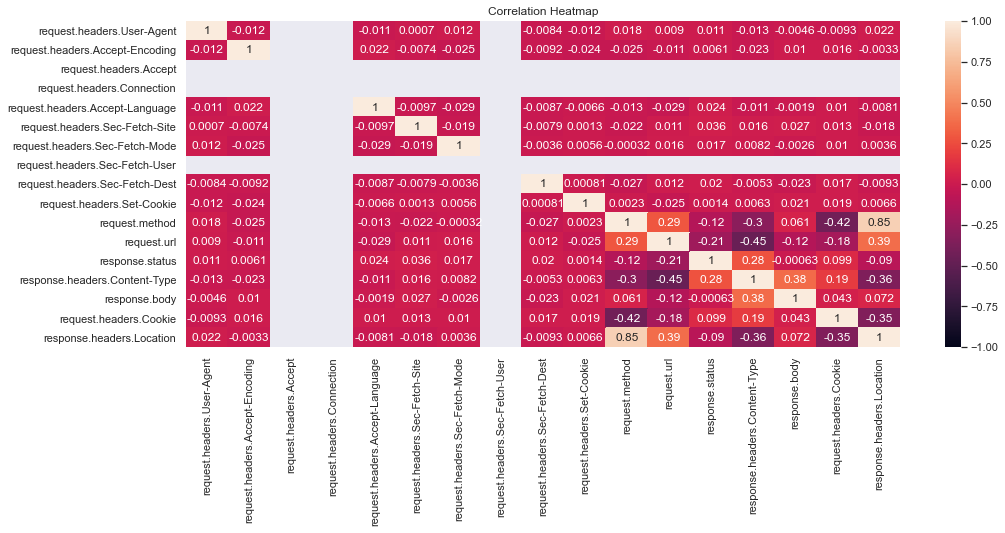

In [241]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

## Train test split¶

In [242]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(3526, 17) (3526,)
(756, 17) (756,)


Counter({'Malware': 2264, 'Benign': 2018})

In [243]:
def numerize(row):
    if row['label'] == 'Benign':
        return 0
    return 1

df['tag_num'] = df.apply(lambda row: numerize(row), axis=1)
df

,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.body,request.headers.Cookie,response.headers.Location,attack_type,label,tag_num
0,-0.235702,0,0,0,1,0,0,0,0,0.192450,0,0.000000,0,0.000000,0.301511,0.000000,0.0,Directory Traversal,Malware,1
1,0.000000,0,0,0,0,0,0,0,0,0.259828,0,-0.894427,4,0.000000,0.666667,0.000000,0.0,Benign,Benign,0
2,0.577350,0,0,0,0,0,0,0,0,-0.176090,0,0.707107,0,-0.408248,-1.000000,-0.316228,0.0,Cookie Injection,Malware,1
3,-0.666667,0,0,0,1,0,0,0,0,0.215387,0,0.000000,4,0.000000,0.894427,0.000000,0.0,Benign,Benign,0
4,0.577350,0,0,0,0,0,0,0,29,0.274721,0,-0.577350,4,0.000000,0.666667,0.000000,0.0,LOG4J,Malware,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,0.000000,0,0,0,2,0,1,0,0,0.000000,1,0.707107,1,-0.408248,0.154303,0.000000,1.0,Cookie Injection,Malware,1
4278,0.000000,0,0,0,0,0,0,0,0,0.381000,0,0.000000,4,0.000000,-0.447214,0.000000,0.0,Benign,Benign,0
4279,0.000000,0,0,0,1,0,0,0,0,-0.371391,1,0.707107,1,-0.408248,0.154303,0.000000,1.0,Cookie Injection,Malware,1
4280,0.000000,0,0,0,1,0,0,0,0,-0.588348,0,-0.447214,4,0.000000,0.666667,0.000000,0.0,Benign,Benign,0


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


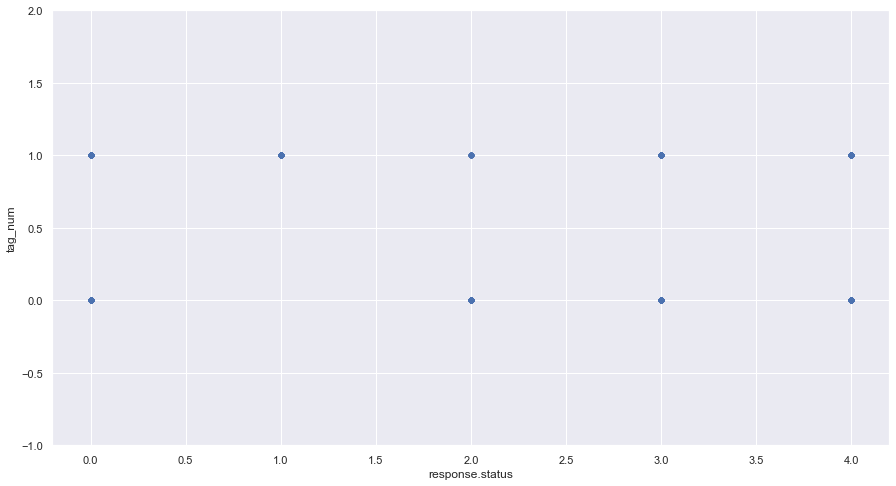

In [244]:
#Relationship with numerical variables
var = 'response.status'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); # do not `assume here any thing this is just examples

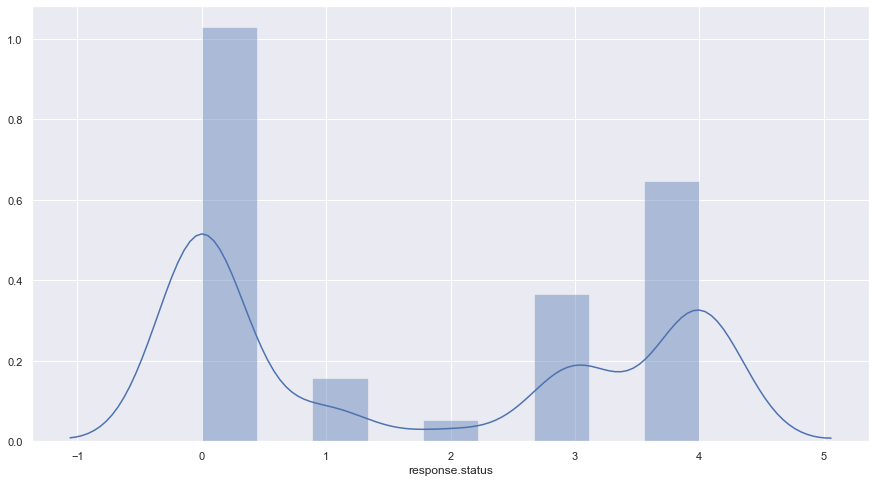

In [245]:
sns.distplot(df['response.status'])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


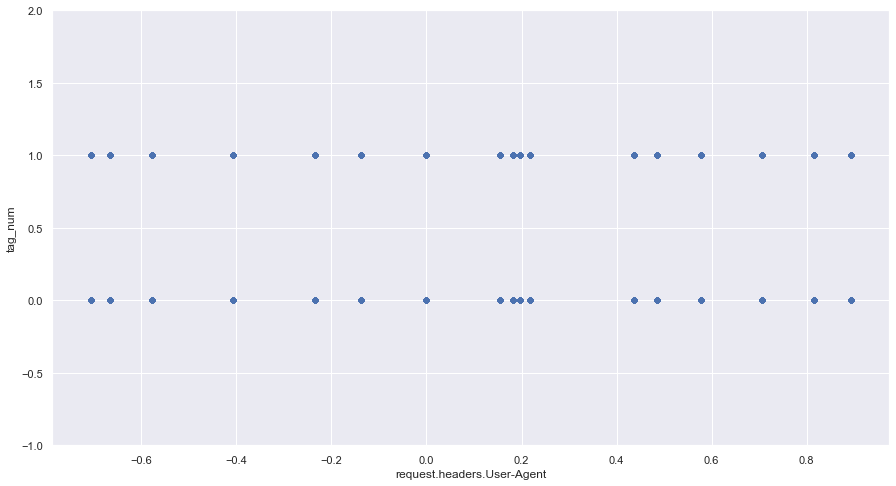

In [246]:
#Relationship with numerical variables
var = 'request.headers.User-Agent'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); # do not `assume here any thing this is just examples

## Model choosing and fitting 

### Random Forest

In [247]:
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier(n_estimators=37)

# Train Model
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


## Result printout 

              precision    recall  f1-score   support

      Benign    0.91667   0.92697   0.92179       356
     Malware    0.93434   0.92500   0.92965       400

    accuracy                        0.92593       756
   macro avg    0.92551   0.92598   0.92572       756
weighted avg    0.92602   0.92593   0.92595       756



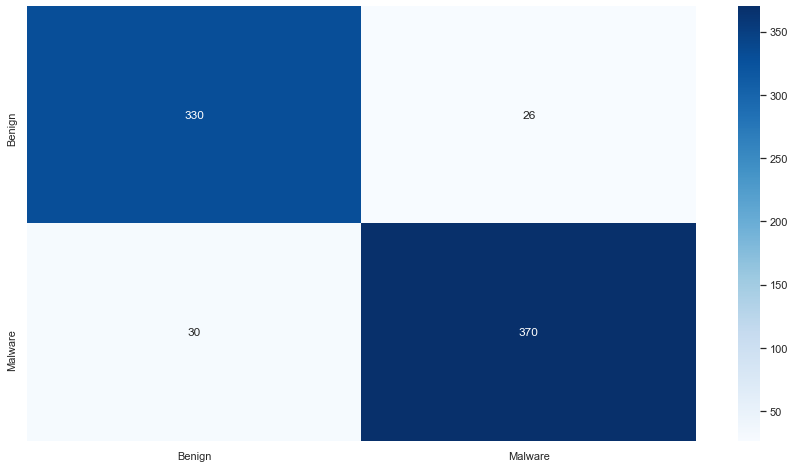

In [248]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

### Naive Bayes

In [249]:
from sklearn.naive_bayes import GaussianNB
logisticRegr = GaussianNB()
logisticRegr.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.53534   1.00000   0.69736       356
     Malware    1.00000   0.22750   0.37067       400

    accuracy                        0.59127       756
   macro avg    0.76767   0.61375   0.53401       756
weighted avg    0.78119   0.59127   0.52451       756



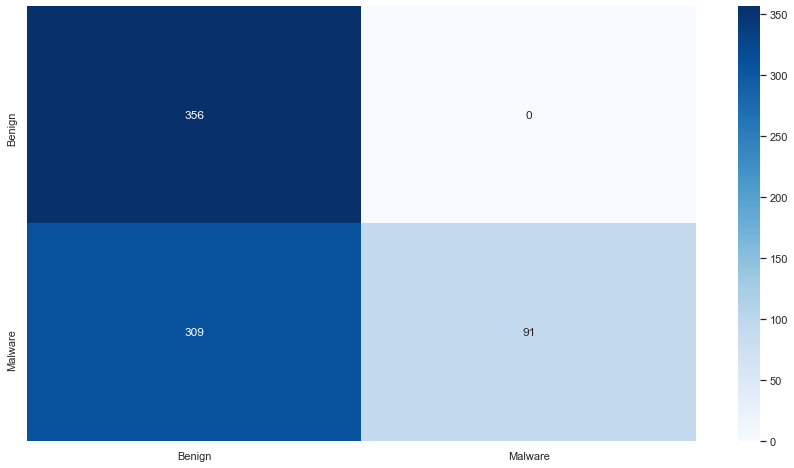

In [250]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = logisticRegr.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

# SVM- try

In [251]:
from sklearn import svm

logisticRegr = svm.SVC(kernel='linear', C=0.9)
# y_train[:] = [x if x != 'Benign' else 0 for x in y_train]
# y_train[:] = [x if x != 'Malware' else 1 for x in y_train]
logisticRegr.fit(X_train, y_train)
# # Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.65797   0.63764   0.64765       356
     Malware    0.68613   0.70500   0.69544       400

    accuracy                        0.67328       756
   macro avg    0.67205   0.67132   0.67154       756
weighted avg    0.67287   0.67328   0.67293       756



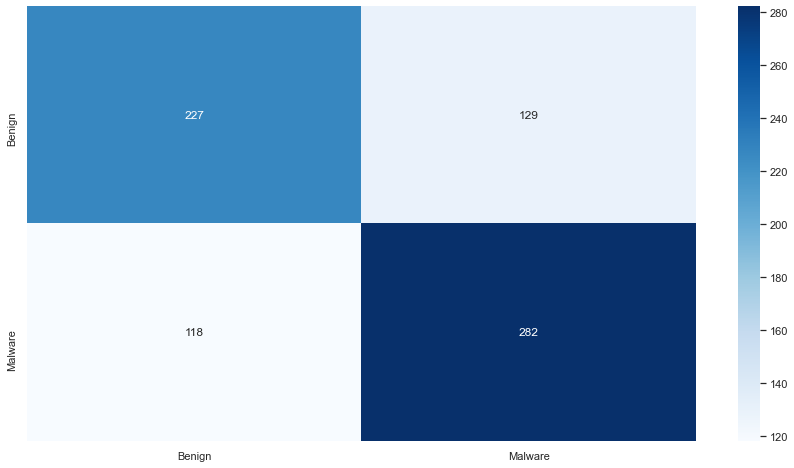

In [252]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = logisticRegr.predict(X_test)
# prediction[:] = [x if x != 'Benign' else 0 for x in prediction]
# prediction[:] = [x if x != 'Malware' else 1 for x in prediction]
true_labels = y_test
# y_test[:] = [x if x != 'Benign' else 0 for x in y_test]
# y_test[:] = [x if x != 'Malware' else 1 for x in y_test]
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### Dummy

In [253]:
from sklearn.dummy import DummyClassifier

dum = DummyClassifier(strategy='stratified')
dum.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.50725   0.49157   0.49929       356
     Malware    0.55961   0.57500   0.56720       400

    accuracy                        0.53571       756
   macro avg    0.53343   0.53329   0.53324       756
weighted avg    0.53495   0.53571   0.53522       756



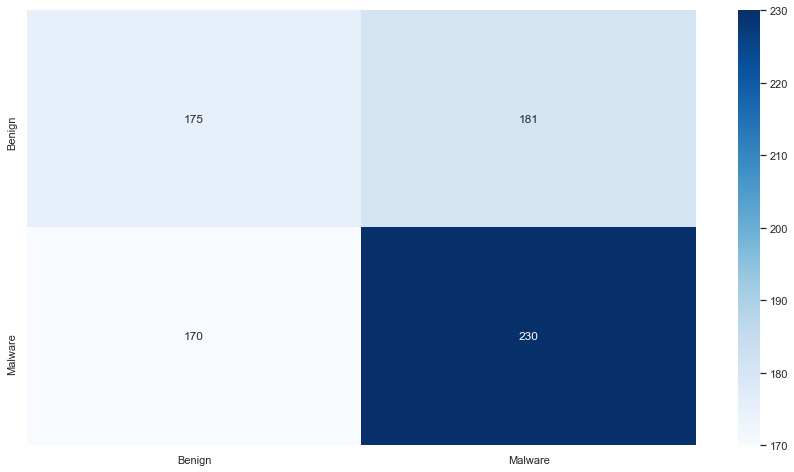

In [254]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = dum.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### KNN

In [255]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.94014   0.75000   0.83437       356
     Malware    0.81144   0.95750   0.87844       400

    accuracy                        0.85979       756
   macro avg    0.87579   0.85375   0.85641       756
weighted avg    0.87205   0.85979   0.85769       756



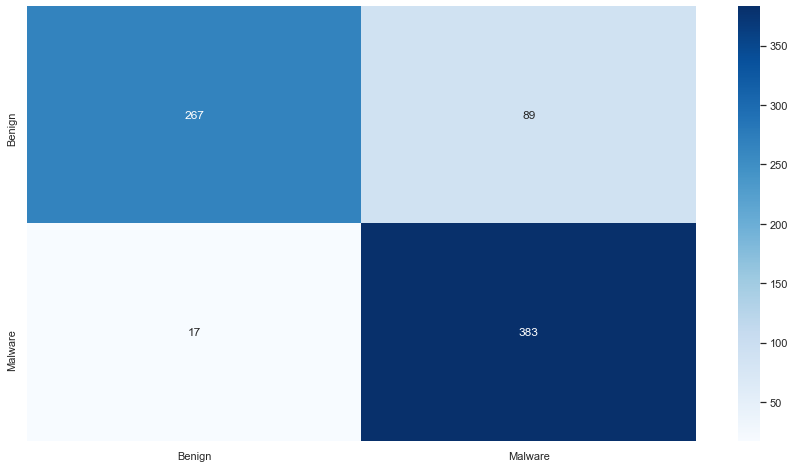

In [256]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = knn.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### Ridge

In [257]:
from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier(alpha=0.5).fit(X_train, y_train)
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.67805   0.78090   0.72585       356
     Malware    0.77457   0.67000   0.71850       400

    accuracy                        0.72222       756
   macro avg    0.72631   0.72545   0.72217       756
weighted avg    0.72912   0.72222   0.72196       756



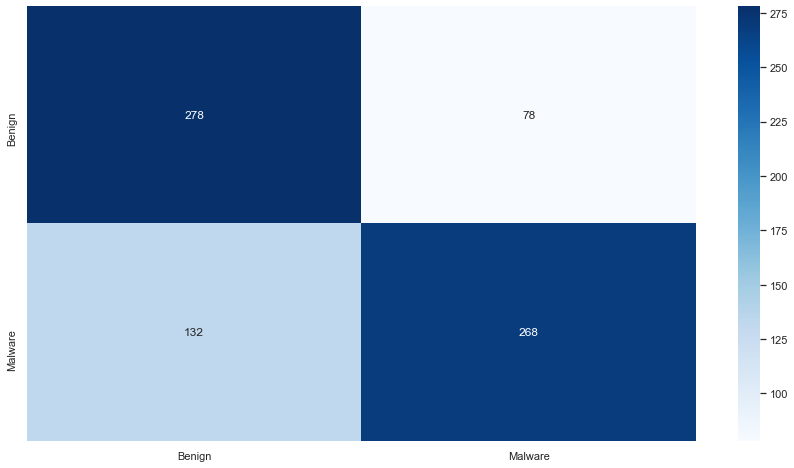

In [258]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = ridge.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### SVM SVC

In [259]:
svc = svm.SVC(gamma = 'auto')
svc.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.94891   0.73034   0.82540       356
     Malware    0.80083   0.96500   0.87528       400

    accuracy                        0.85450       756
   macro avg    0.87487   0.84767   0.85034       756
weighted avg    0.87056   0.85450   0.85179       756



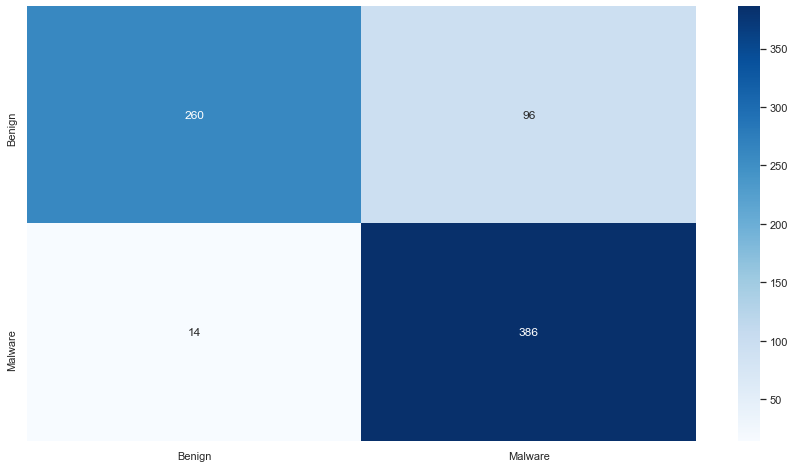

In [260]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = svc.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### Ada boost

## Best classifier before changing feature selection

In [261]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=130)
ada.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.94578   0.88202   0.91279       356
     Malware    0.90094   0.95500   0.92718       400

    accuracy                        0.92063       756
   macro avg    0.92336   0.91851   0.91999       756
weighted avg    0.92206   0.92063   0.92041       756



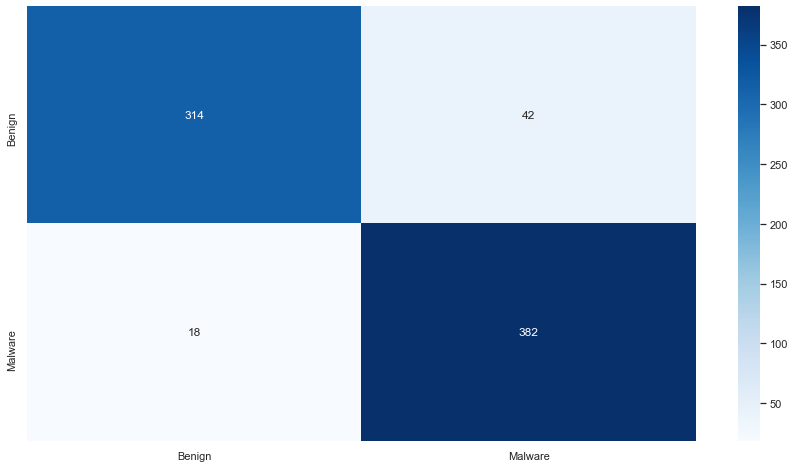

In [262]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = ada.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### Stacking

## Best classifier after changing the feature selection

In [263]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators = [('Ada Boost', ada), ('Random forest', clf)],
                           final_estimator = svc, n_jobs = -1) 
stack.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.91351   0.94944   0.93113       356
     Malware    0.95337   0.92000   0.93639       400

    accuracy                        0.93386       756
   macro avg    0.93344   0.93472   0.93376       756
weighted avg    0.93460   0.93386   0.93391       756



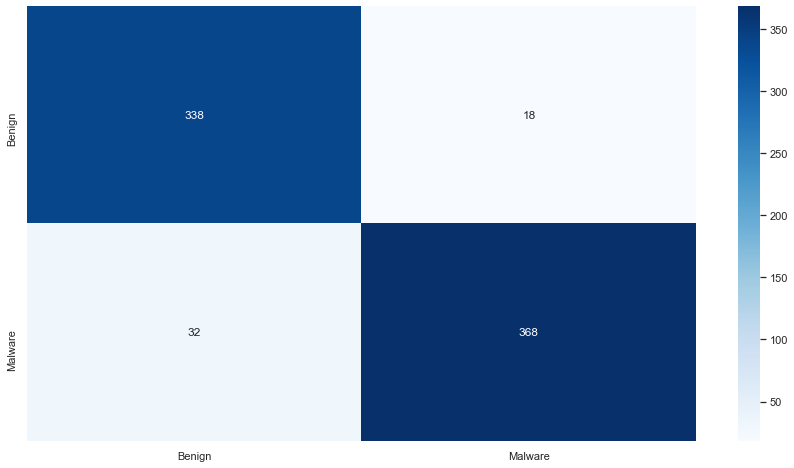

In [264]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = stack.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## hard voting

### best classifier after dropping more features

In [265]:
from sklearn.ensemble import VotingClassifier

vot = VotingClassifier(estimators = [('Ada Boost', ada), ('Random forest', clf)], voting='hard')
vot.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.92521   0.93820   0.93166       356
     Malware    0.94430   0.93250   0.93836       400

    accuracy                        0.93519       756
   macro avg    0.93476   0.93535   0.93501       756
weighted avg    0.93531   0.93519   0.93521       756



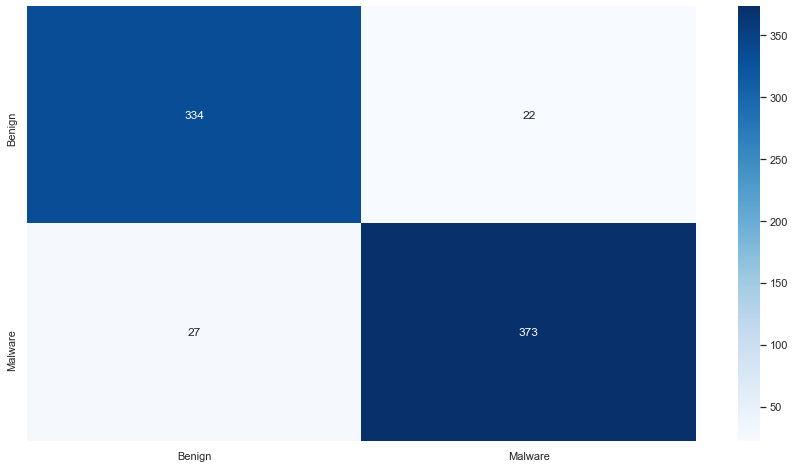

In [266]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = vot.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### soft voting

In [267]:
vot = VotingClassifier(estimators = [('Ada Boost', ada), ('Random forest', clf)], voting='soft')
vot.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.91736   0.93539   0.92629       356
     Malware    0.94148   0.92500   0.93317       400

    accuracy                        0.92989       756
   macro avg    0.92942   0.93020   0.92973       756
weighted avg    0.93012   0.92989   0.92993       756



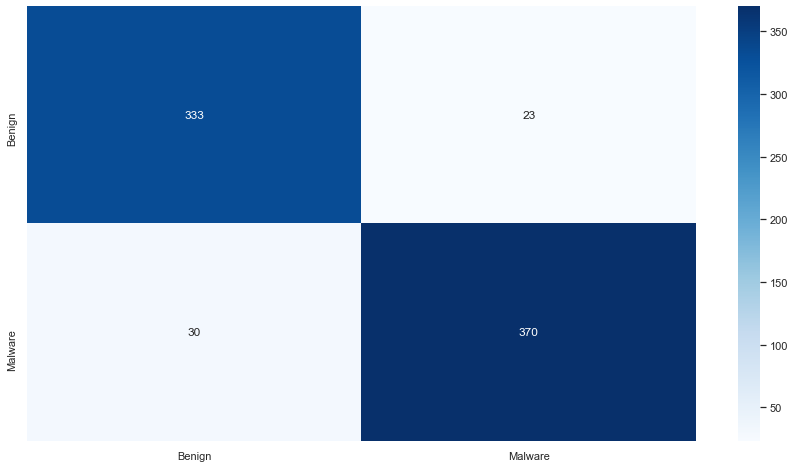

In [268]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = vot.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## Validation

In [45]:
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,request.headers.Content-Length,response.headers.Location,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=dVlNEpf8NxpyzA7muTOQZq27dstyz3vLvC3KTFuL7...,"Mon, 21 Nov 2022 18:39:55 GMT",GET,http://127.0.0.1:5000/orders/check/exists/9701,,404 NOT FOUND,text/html; charset=utf-8,207,404,<!doctype html>\n<html lang=en>\n<title>404 No...,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=PY7dmka20pTIpRcGuLe1VPC17-BM9dFTDxFDvBiyB...,"Mon, 21 Nov 2022 18:39:56 GMT",GET,http://127.0.0.1:5000/categories/check/number/...,,404 NOT FOUND,application/json,43,404,"{""error"": ""Category number not found""}",NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=P2xUfJ_H_sPMvdBExjCc4-IpiOVF2gC3D9FfvZSLY...,"Mon, 21 Nov 2022 18:39:57 GMT",GET,http://127.0.0.1:5000/states/6885,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=vVS_oJohZvCG9m9gekak9nJThQlQMi1yKVQMPUP-P...,"Mon, 21 Nov 2022 18:39:57 GMT",GET,http://127.0.0.1:5000/states/10070,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:27...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=q0CwX5jOFhPJhae8pwXSjGuVec609HBBwppoXrjXG...,"Mon, 21 Nov 2022 18:39:58 GMT",GET,http://127.0.0.1:5000/about/greet,,200 OK,text/html; charset=utf-8,664,200,<p>If you get stuck or just want to check your...,NaN,NaN,NaN,NaN


In [46]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,request.headers.Content-Length,response.headers.Location,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=dVlNEpf8NxpyzA7muTOQZq27dstyz3vLvC3KTFuL7...,"Mon, 21 Nov 2022 18:39:55 GMT",GET,http://127.0.0.1:5000/orders/check/exists/9701,,404 NOT FOUND,text/html; charset=utf-8,207,404,<!doctype html>\n<html lang=en>\n<title>404 No...,None,None,None,None
1,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=PY7dmka20pTIpRcGuLe1VPC17-BM9dFTDxFDvBiyB...,"Mon, 21 Nov 2022 18:39:56 GMT",GET,http://127.0.0.1:5000/categories/check/number/...,,404 NOT FOUND,application/json,43,404,"{""error"": ""Category number not found""}",None,None,None,None
2,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=P2xUfJ_H_sPMvdBExjCc4-IpiOVF2gC3D9FfvZSLY...,"Mon, 21 Nov 2022 18:39:57 GMT",GET,http://127.0.0.1:5000/states/6885,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",None,None,None,None
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=vVS_oJohZvCG9m9gekak9nJThQlQMi1yKVQMPUP-P...,"Mon, 21 Nov 2022 18:39:57 GMT",GET,http://127.0.0.1:5000/states/10070,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",None,None,None,None
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:27...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=q0CwX5jOFhPJhae8pwXSjGuVec609HBBwppoXrjXG...,"Mon, 21 Nov 2022 18:39:58 GMT",GET,http://127.0.0.1:5000/about/greet,,200 OK,text/html; charset=utf-8,664,200,<p>If you get stuck or just want to check your...,None,None,None,None


In [238]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                'request.headers.Connection',
                'request.headers.Host',
                'request.headers.Accept',
                'request.method',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Site',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.Sec-Fetch-Dest',
                'request.headers.Sec-Fetch-User',
                'response.status',
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                    'request.headers.Set-Cookie',
                    'request.headers.Date',
                    'request.url',
                    'response.headers.Content-Type',
                    'response.body',
                    'response.headers.Location',
                    'request.headers.Content-Length',
                    'request.headers.Cookie',
                    'response.headers.Set-Cookie'
                    ]

COLUMNS_TO_REMOVE = ['request.body',
                    'response.headers.Content-Length',
                    'request.headers.Date']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=3)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.status_code,response.body,request.headers.Cookie,request.headers.Content-Length,response.headers.Location,response.headers.Set-Cookie
0,0,0.894427,0,0,0,0,0,0,0,0,0.000000,0,0.577350,4,-0.408248,404,-0.801784,0.0,0.0,0.0,0.0
1,0,0.707107,0,0,0,0,0,0,0,0,0.529813,0,-0.577350,4,0.000000,404,0.554700,0.0,0.0,0.0,0.0
2,0,0.707107,0,0,0,1,0,1,0,0,0.341882,0,-0.577350,4,0.000000,404,0.707107,0.0,0.0,0.0,0.0
3,0,0.000000,0,0,0,3,0,0,0,0,0.639602,0,-0.447214,4,0.000000,404,0.707107,0.0,0.0,0.0,0.0
4,0,0.000000,0,0,0,0,0,1,0,0,0.620174,0,0.000000,0,-0.408248,200,0.000000,0.0,0.0,0.0,0.0


In [242]:
df.drop('response.headers.Set-Cookie', axis=1, inplace=True)
# df.drop('request.method', axis=1, inplace=True)
df.drop('response.status_code', axis=1, inplace=True)
# df.drop('response.headers.Location', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.body,request.headers.Cookie,request.headers.Content-Length,response.headers.Location
0,0,0.894427,0,0,0,0,0,0,0,0,0.000000,0,0.577350,4,-0.408248,-0.801784,0.0,0.0,0.0
1,0,0.707107,0,0,0,0,0,0,0,0,0.529813,0,-0.577350,4,0.000000,0.554700,0.0,0.0,0.0
2,0,0.707107,0,0,0,1,0,1,0,0,0.341882,0,-0.577350,4,0.000000,0.707107,0.0,0.0,0.0
3,0,0.000000,0,0,0,3,0,0,0,0,0.639602,0,-0.447214,4,0.000000,0.707107,0.0,0.0,0.0
4,0,0.000000,0,0,0,0,0,1,0,0,0.620174,0,0.000000,0,-0.408248,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,0,-0.666667,0,0,0,2,0,0,0,0,-0.111111,0,-0.408248,0,0.000000,-0.872872,0.0,0.0,0.0
751,0,0.000000,0,0,0,3,0,0,0,0,-0.140028,0,0.707107,0,-0.408248,-0.447214,0.0,0.0,0.0
752,0,-0.235702,0,0,0,0,0,1,0,0,0.000000,0,0.000000,0,-0.408248,0.929981,0.0,0.0,0.0
753,0,0.182574,0,0,0,0,0,0,0,0,0.182574,0,0.707107,0,-0.408248,-0.577350,0.0,0.0,0.0


In [243]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   request.headers.Host             755 non-null    int32  
 1   request.headers.User-Agent       755 non-null    float64
 2   request.headers.Accept-Encoding  755 non-null    int32  
 3   request.headers.Accept           755 non-null    int32  
 4   request.headers.Connection       755 non-null    int32  
 5   request.headers.Accept-Language  755 non-null    int32  
 6   request.headers.Sec-Fetch-Site   755 non-null    int32  
 7   request.headers.Sec-Fetch-Mode   755 non-null    int32  
 8   request.headers.Sec-Fetch-User   755 non-null    int32  
 9   request.headers.Sec-Fetch-Dest   755 non-null    int32  
 10  request.headers.Set-Cookie       755 non-null    float64
 11  request.method                   755 non-null    int32  
 12  request.url           

In [244]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.Host', 'request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept', 'request.headers.Connection', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-User', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Type', 'response.body', 'request.headers.Cookie', 'request.headers.Content-Length', 'response.headers.Location']


request.headers.Host                 int32
request.headers.User-Agent         float64
request.headers.Accept-Encoding      int32
request.headers.Accept               int32
request.headers.Connection           int32
request.headers.Accept-Language      int32
request.headers.Sec-Fetch-Site       int32
request.headers.Sec-Fetch-Mode       int32
request.headers.Sec-Fetch-User       int32
request.headers.Sec-Fetch-Dest       int32
request.headers.Set-Cookie         float64
request.method                       int32
request.url                        float64
response.status                      int32
response.headers.Content-Type      float64
response.body                      float64
request.headers.Cookie             float64
request.headers.Content-Length     float64
response.headers.Location          float64
dtype: object

In [245]:
val = df[features_list].to_numpy()

sns.set(rc={'figure.figsize':(15,8)})
prediction = stack.predict(val)
print(prediction)

['Benign' 'Benign' 'Benign' 'Benign' 'Benign' 'Malware' 'Malware'
 'Malware' 'Benign' 'Benign' 'Benign' 'Benign' 'Benign' 'Benign' 'Benign'
 'Benign' 'Malware' 'Benign' 'Malware' 'Malware' 'Benign' 'Malware'
 'Benign' 'Malware' 'Malware' 'Benign' 'Malware' 'Malware' 'Benign'
 'Malware' 'Benign' 'Malware' 'Benign' 'Benign' 'Malware' 'Malware'
 'Benign' 'Malware' 'Benign' 'Benign' 'Malware' 'Benign' 'Malware'
 'Benign' 'Malware' 'Benign' 'Benign' 'Malware' 'Benign' 'Benign'
 'Malware' 'Malware' 'Benign' 'Malware' 'Benign' 'Malware' 'Malware'
 'Benign' 'Benign' 'Benign' 'Malware' 'Benign' 'Malware' 'Malware'
 'Malware' 'Benign' 'Malware' 'Malware' 'Benign' 'Benign' 'Malware'
 'Benign' 'Benign' 'Benign' 'Malware' 'Benign' 'Benign' 'Malware' 'Benign'
 'Malware' 'Malware' 'Benign' 'Benign' 'Malware' 'Malware' 'Benign'
 'Malware' 'Benign' 'Benign' 'Benign' 'Malware' 'Benign' 'Benign' 'Benign'
 'Benign' 'Benign' 'Malware' 'Malware' 'Benign' 'Malware' 'Benign'
 'Benign' 'Malware' 'Malware' 'Ben